In [1]:
import os
import sys
from pathlib import Path

cwd_path = cwd_path = Path(os.getcwd()).absolute().parents[0]
parent_path = cwd_path.parents[0]
sys.path.insert(0, parent_path.as_posix())
sys.path.insert(0, cwd_path.parents[0].parents[0].as_posix()) # Root

import numpy as np
from scipy.io import loadmat  # loading data from matlab
from mayavi import mlab
import matplotlib.pyplot as plt
from pymanopt.manifolds import Euclidean, Sphere, Product

from SkillsSequencing.skills.mps.gmr.manifold_statistics import compute_frechet_mean, compute_weighted_frechet_mean
from SkillsSequencing.skills.mps.gmr.manifold_clustering import manifold_k_means, manifold_gmm_em
from SkillsSequencing.skills.mps.gmr.manifold_gmr import manifold_gmr
from SkillsSequencing.utils.plot_sphere_mayavi import plot_sphere, plot_gaussian_mesh_on_tangent_plane

from SkillsSequencing.skills.mps.dynsys.CALVIN_DS import CALVINDynSysDataset
from SkillsSequencing.skills.mps.dynsys.utils import plot_3d_trajectories

KeyboardInterrupt: 

### Load Data

In [ ]:
skill = 'rotate_blue_block_right'
dataset = CALVINDynSysDataset(skill=skill, state_type='ori', is_quaternion=True, train=True, normalized=False, goal_centered=False, demos_dir='data/')
# dataset.plot_random()

In [ ]:
np.linalg.norm(dataset.X[0][0])

### Parameters

In [ ]:
nb_data = dataset.X[0].shape[0]
nb_data_sup = 62
nb_samples = 30
dt = 0.06
sampling_dt = 0.03
input_dim = 4
output_dim = 4
nb_states = 3

In [ ]:
# Create velocity data
# demos_dx = np.array([(demos[i][2:, :] - demos[i][:-2, :])/dt for i in range(nb_samples)])
# demos = [demos[i][1:-1, :] for i in range(nb_samples)]

# Stack position and velocity data
demos_xdx = [np.hstack([dataset.X[i], dataset.dX[i]]) for i in range(nb_samples)]

# Stack demos
demos_np = demos_xdx[0]
for i in range(1, nb_samples):
    demos_np = np.vstack([demos_np, demos_xdx[i]])

In [ ]:
X = demos_np[:, :input_dim]
Y = demos_np[:, input_dim:]

# X = 2 * (X - np.min(X, axis=0))/ (np.max(X, axis=0) - np.min(X, axis=0))
# X_norm = np.linalg.norm(X, axis=1)[:, None]
# X = X / np.linalg.norm(X, axis=1)[:, None]


# Y = 2 * (Y - np.min(Y, axis=0))/ (np.max(Y, axis=0) - np.min(Y, axis=0))
# Y_norm = np.linalg.norm(Y, axis=1)[:, None]
# Y = Y / np.linalg.norm(Y, axis=1)[:, None]


In [ ]:
# Data in format compatible with pymanopt product of manifolds
data = np.empty((X.shape[0], 2), dtype=object)
for n in range(X.shape[0]):
    data[n] = [X[n], Y[n]]

In [ ]:
data.shape

In [ ]:
# Xt = dt * np.arange(nb_data + nb_data_sup)[:, None]

# Create the manifold
input_manifold = Sphere(input_dim)
output_manifold = Sphere(output_dim)
manifold = Product([input_manifold, output_manifold])

# Number of clusters
nb_clusters = 3

In [10]:
data[0]

array([array([ 0.7560201 ,  0.6537286 , -0.01600595,  0.02857106], dtype=float32),
       array([ 0.04151532, -0.05009251,  0.04883759,  0.07671842], dtype=float32)],
      dtype=object)

In [11]:
# K-means
km_means, km_assignments = manifold_k_means(manifold, data, nb_clusters=nb_clusters)

# GMM
initial_covariances = np.concatenate(nb_clusters * [np.eye(input_dim+output_dim)[None]], 0)
initial_priors = np.zeros(nb_clusters)
for k in range(nb_clusters):
    initial_priors[k] = np.sum(km_assignments == k) / len(km_assignments)
gmm_means, gmm_covariances, gmm_priors, gmm_assignments = manifold_gmm_em(manifold, data, nb_clusters,
                                                                          initial_means=km_means,
                                                                          initial_covariances=initial_covariances,
                                                                          initial_priors=initial_priors)
outdir = f'skill_ds/{dataset.state_type}/{dataset.skill}/gmm/'
os.makedirs(outdir, exist_ok=True)
filename = outdir + f'gmm_params{nb_clusters}.npz'
np.savez(filename, gmm_means=gmm_means, gmm_covariances=gmm_covariances, gmm_priors=gmm_priors)

Converged after 6 iterations: 1.176e+01


In [12]:
sampling_dt = 0.03
val_dataset = CALVINDynSysDataset(skill=skill, state_type='ori', is_quaternion=True, goal_centered=False, normalized=False, train=False, demos_dir='data/')
X_val = val_dataset.X[0]
for i in range(1, val_dataset.X.shape[0]):
    X_val = np.vstack([X_val, val_dataset.X[i]])

In [40]:
X_val[0]

array([ 0.7090184 ,  0.7046077 ,  0.02674841, -0.01026431], dtype=float32)

In [52]:
rand_idx = np.random.choice(np.arange(0, len(X_val), nb_data))
# rand_idx = 62
sampled_path = []
x0 = np.copy(X_val[rand_idx, :])
goal = np.copy(X_val[rand_idx+nb_data-1, :])
new_x = x0

for i in range(100):
    x_dot, sigma_gmr, H = manifold_gmr(new_x.reshape(1, -1), manifold, gmm_means, gmm_covariances, gmm_priors)
    new_x = new_x + sampling_dt * x_dot
    new_x = new_x / np.linalg.norm(new_x)
    sampled_path.append(new_x)
    if np.linalg.norm(new_x - goal) <= 0.03:
        break
sampled_path = np.array(sampled_path).squeeze(1)
true_path = X_val[rand_idx:rand_idx+nb_data]
print(rand_idx, len(sampled_path))

744 100


In [43]:
new_x.dtype

dtype('float64')

## Visualizing Quaternion Trajectories. 

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.animation as animation
import numpy as np
from PIL import Image
import pybullet as p
import io

In [45]:
def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def add_vectors(v1, v2):
    return [v_1 + v_2 for v_1, v_2 in zip(v1, v2)]

def subtract_vectors(v1, v2):
    return [v_1 - v_2 for v_1, v_2 in zip(v1, v2)]

In [46]:
def plt2arr(fig, draw=True):
    """
    need to draw if figure is not drawn yet
    """
    if draw:
        fig.canvas.draw()
    rgba_buf = fig.canvas.buffer_rgba()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h,w,4))
    return rgba_arr

In [47]:
buffer = 0.1
minx = -buffer
maxx = +buffer

miny = - buffer
maxy = + buffer

minz = - buffer
maxz = + buffer

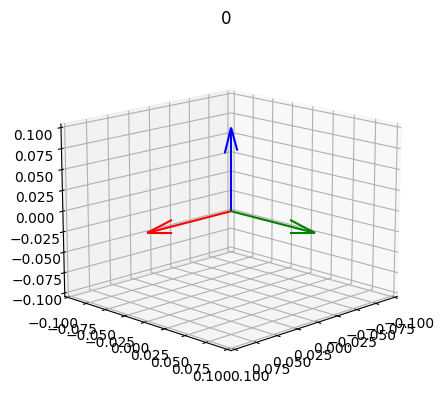

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]
origin = [0.0, 0.0, 0.0]
# origin = dataset.X[0][0][:3]
OX, OY, OZ = zip(origin) 

ax.quiver(OX, OY, OZ, X[0],X[1], X[2], color='red')
ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
ax.quiver(OX, OY, OZ, Z[0],Z[1],Z[2], color='blue')
# ax.scatter(OX, OY, OZ, color='gray')
ax.view_init(elev=15, azim=45)
ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
ax.set_title("0")
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
plt.show()
plt.close(fig)

In [14]:

frames = []
X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]
for idx, q in enumerate(true_path):
    q = np.array([q[-1], q[0], q[1], q[2]])
    X = qv_mult(q, tuple(X))
    Y = qv_mult(q, tuple(Y))
    Z = qv_mult(q, tuple(Z))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(OX, OY, OZ, X[0], X[1], X[2], color='red')
    ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
    ax.quiver(OX, OY, OZ, Z[0], Z[1], Z[2], color='blue')
    
    ax.view_init(elev=15, azim=40)
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
    ax.set_title(skill + ' - GT - ' + str(idx+1))
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_zticks([])

    frames.append(plt2arr(fig, True))
    plt.close(fig)
#     X = [1/10, 0, 0]
#     Y = [0, 1/10, 0]
#     Z = [0, 0, 1/10]

X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]
for idx, q in enumerate(sampled_path):
    q = np.array([q[-1], q[0], q[1], q[2]])
    X = qv_mult(q, tuple(X))
    Y = qv_mult(q, tuple(Y))
    Z = qv_mult(q, tuple(Z))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(OX, OY, OZ, X[0], X[1], X[2], color='red')
    ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
    ax.quiver(OX, OY, OZ, Z[0], Z[1], Z[2], color='blue')
    
    ax.view_init(elev=15, azim=45)
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
    ax.set_title(skill + ' Sampled - ' + str(idx+1))
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_zticks([])

    frames.append(plt2arr(fig, True))
    plt.close(fig)
#     X = [1/10, 0, 0]
#     Y = [0, 1/10, 0]
#     Z = [0, 0, 1/10]

gif = [Image.fromarray(img) for img in frames]
gif[0].save("quat_demo_rotation.gif", save_all=True, append_images=gif[1:], duration=150, loop=0)
print(rand_idx)

NameError: name 'true_path' is not defined

### Misc

In [112]:



# plt.show()
# ax.axis([-1.5,1.5,-1.5,1.5])



if False:
    def init():
        ax.view_init(elev=28, azim=0)
        return fig,
    
    def animate(i):
        ax.view_init(elev=28, azim=i)
        return fig,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=60, interval=30, blit=True)
    # Save
    anim.save('quat.gif', fps=15)